# 1. Imports and Configs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd

In [2]:
# Execute only the processing blocks
LIMITED_RUN = False

# Create Dataset without sattelite data or wind data
without_sat = False
without_wind = False

# dataset_path: Downloaded Processed Dataset.hp path from https://drive.google.com/file/d/1-23G6s6GmZnVOVUV1Cpw-NSpTUUZkldG/view?usp=share_link
# dates_path: Downloaded Dates.csv path from https://drive.google.com/file/d/1EMAJHG5XzyCVsuVRUZKmvniyxcMduMm6/view?usp=sharing
dataset_path = './dataset/Processed_Data.hp'
normalized_dataset_path = './dataset/Normalized_Processed_Data.hp'
dates_csv = './dataset/dates.csv'

In [3]:
# To refrain from editing the original dataset, it will be duplicated and used
!cp $dataset_path $normalized_dataset_path

# 2. Load Data

In [4]:
dataset_dict = h5py.File(normalized_dataset_path, 'r+')
dataset_dict['X'][:,:,:,:].shape

(3697, 128, 128, 11)

In [6]:
dates_csv = pd.read_csv(dates_csv, header=None, names=['file','date'])
dates_csv['date'] = pd.to_datetime(dates_csv['date'])
dates_csv['index'] = [i for i in range(len(dates_csv))]
print(len(dates_csv))

3697


In [7]:
dataset_dict.create_dataset('Index', (len(dates_csv)), maxshape=(None),chunks=True)

<HDF5 dataset "Index": shape (3697,), type "<f4">

In [8]:
dataset_dict['Index'].resize((len(dates_csv)), axis=0)
dataset_dict['Index'][0:] = dates_csv['index']

# 3. Data Preparation

## 3.1 Rain Radar Data

less than 28.861387 : 302796131
less than 57.80611 : 53975
less than 86.75083 : 5759
less than 115.69555 : 1432
less than 144.64027 : 521
less than 173.58499 : 212
less than 202.52972 : 88
less than 231.47444 : 37
less than 260.41916 : 25
less than 289.3639 : 25
less than 318.3086 : 12
less than 347.25333 : 5
less than 376.19806 : 1
less than 405.14276 : 4
less than 434.0875 : 5
less than 463.0322 : 2
less than 491.97693 : 1
less than 520.92163 : 2
less than 549.8664 : 1


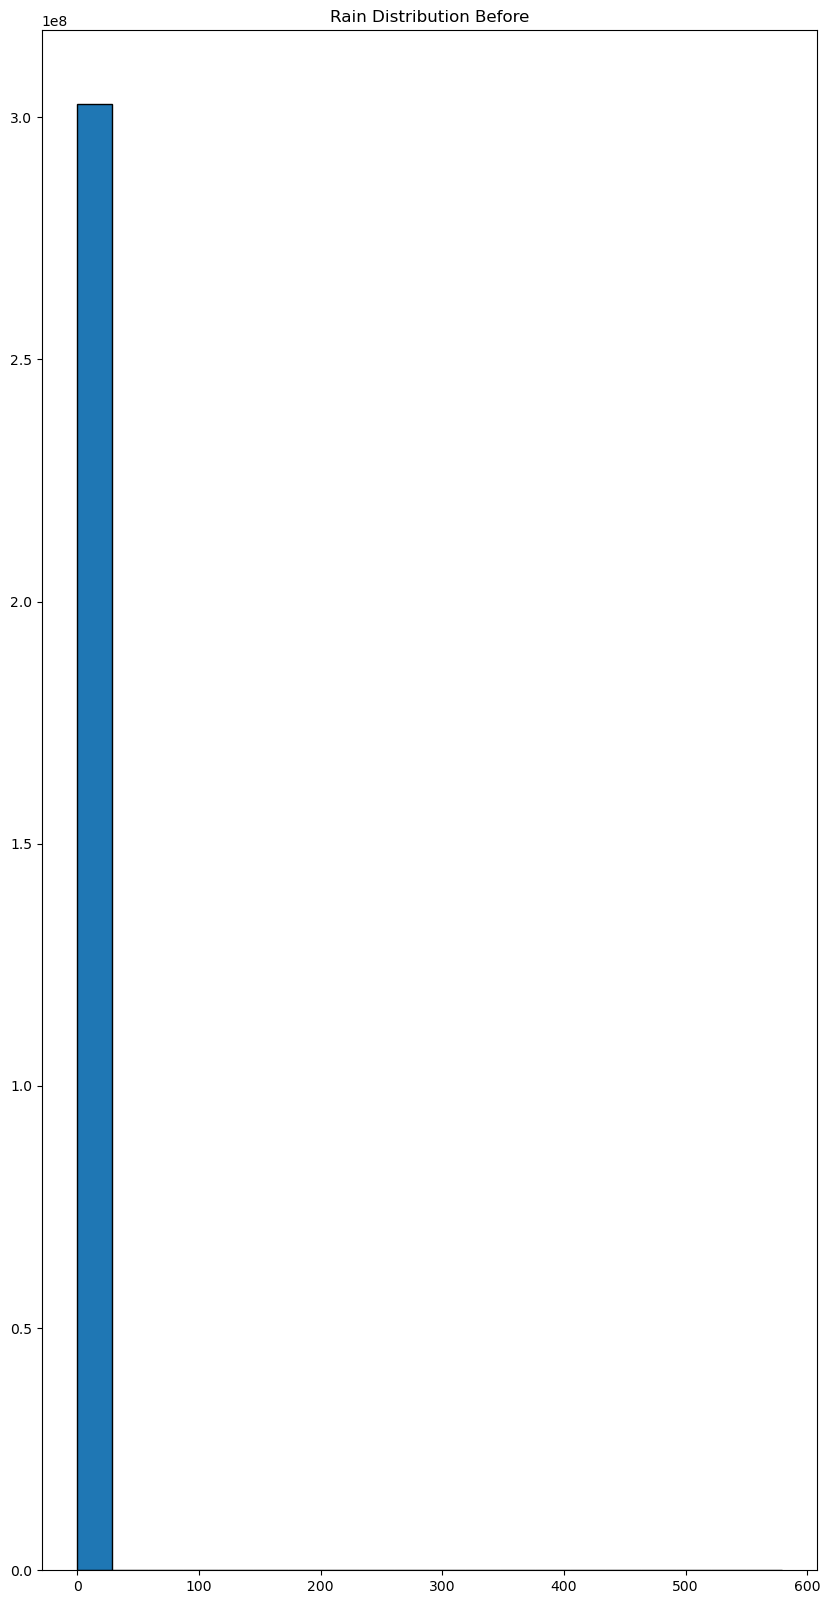

In [9]:
if not LIMITED_RUN:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,:5], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Rain Distribution Before')
    plt.show()

In [10]:
global_min_rain = np.min(dataset_dict['X'][:,:,:,:5])
global_max_rain = np.max(dataset_dict['X'][:,:,:,:5])
print("global_min_rain:", global_min_rain)
print("global_max_rain:", global_max_rain)

global_min_rain: -0.083333336
global_max_rain: 578.8111


In [11]:
# Clipping the rain pixel values at (0, 10/12) since we are predicting rain over 0.1mm/h rain

data_x = dataset_dict['X']
data_x[..., :,:,:,:5] = np.clip(data_x[:,:,:,:5], 0.0, 10/12)

In [12]:
# Log normalizing rain radar data
data_x[..., :,:,:,:5] = np.log(np.add(data_x[:,:,:,:5], 1))/np.log(10/12 + 1)

In [13]:
if not LIMITED_RUN:
    global_mean_rain = np.mean(dataset_dict['X'][:,:,:,:5])
    global_std_rain = np.std(dataset_dict['X'][:,:,:,:5])
    global_min_rain = np.min(dataset_dict['X'][:,:,:,:5])
    global_max_rain = np.max(dataset_dict['X'][:,:,:,:5])
    print("global_mean_rain:", global_mean_rain)
    print("global_std_rain:", global_std_rain)
    print("global_min_rain:", global_min_rain)
    print("global_max_rain:", global_max_rain)

global_mean_rain: 0.23508514
global_std_rain: 0.3751814
global_min_rain: 0.0
global_max_rain: 0.9999999


less than 0.049999993 : 199325291
less than 0.09999999 : 2788549
less than 0.14999998 : 3143793
less than 0.19999997 : 2400759
less than 0.24999997 : 2788073
less than 0.29999995 : 6955281
less than 0.34999996 : 3251802
less than 0.39999995 : 6030931
less than 0.44999996 : 3113696
less than 0.49999994 : 4787825
less than 0.54999995 : 2891152
less than 0.5999999 : 3990622
less than 0.6499999 : 2648038
less than 0.6999999 : 3453116
less than 0.7499999 : 2470142
less than 0.7999999 : 2982237
less than 0.8499999 : 2786196
less than 0.8999999 : 2188637
less than 0.94999987 : 2517685


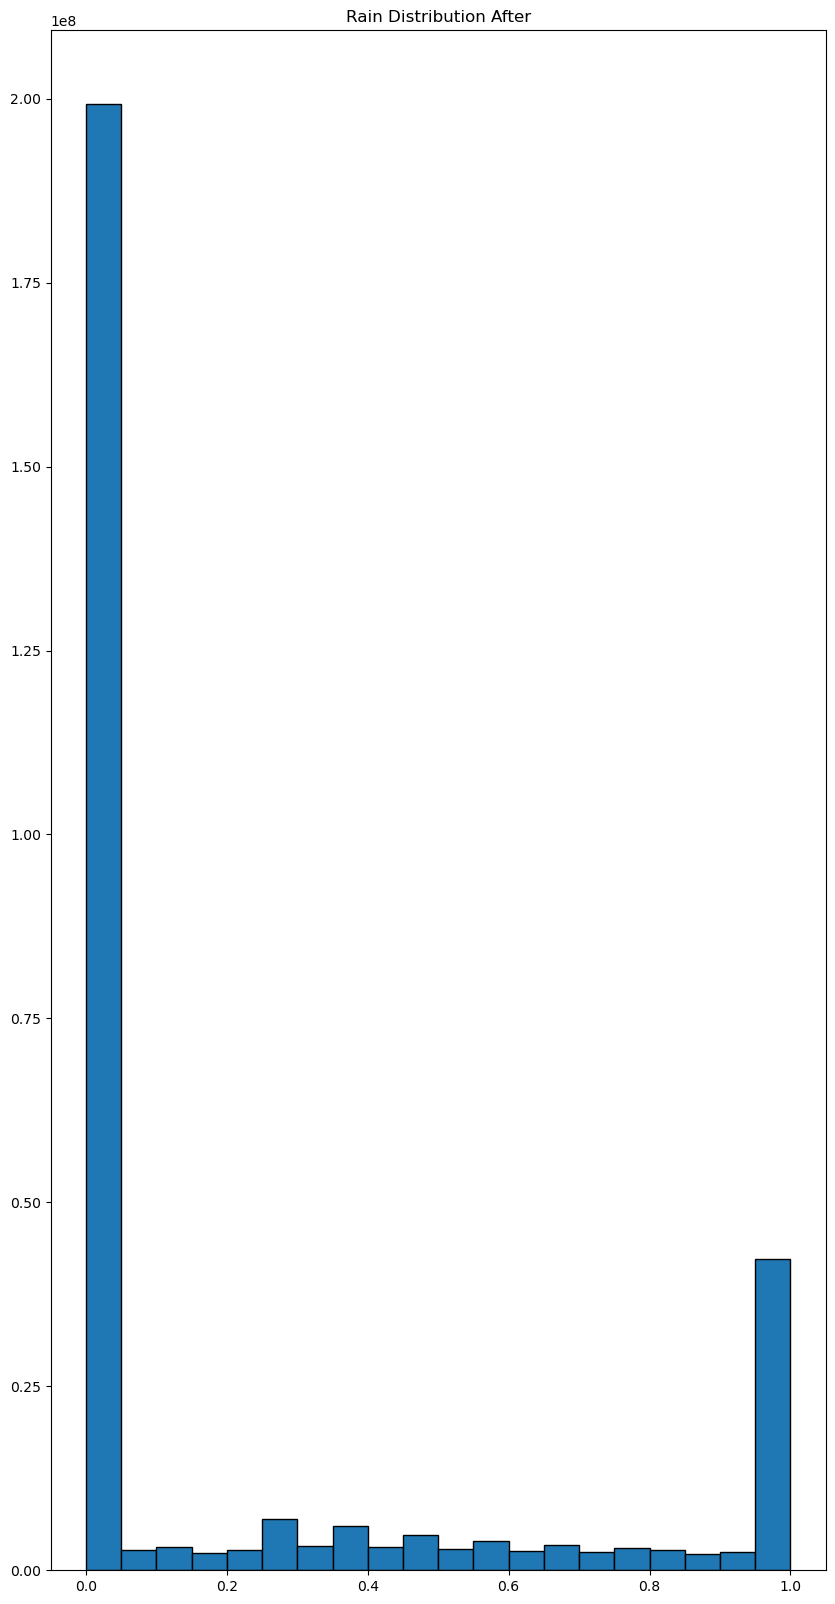

In [14]:
if not LIMITED_RUN:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,:5], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Rain Distribution After')
    plt.show()

In [15]:
dataset_dict['X'].shape

(3697, 128, 128, 11)

In [16]:
dataset_dict['Y'].shape

(3697, 128, 128)

## 3.2 Sat Data Preparation

In [17]:
if not without_sat:
    # Correcting the errors in processed satellite data (Some images in the original data had unreasonable values for several pixels)
    error_data_indexes = list(set(np.where(dataset_dict['X'][:,:,:,-2:]>377)[0]))
    print('Error Indexes:', error_data_indexes)
    data_x_deleted = np.delete(dataset_dict['X'], error_data_indexes, axis=0)
    print('Deleted Data Shape:', data_x_deleted.shape)
    print('dataset_dict[X] Shape Before:', dataset_dict['X'].shape)
    dataset_dict['X'].resize(data_x_deleted.shape)
    data_x = dataset_dict['X']
    data_x[...] = data_x_deleted

    data_y_deleted = np.delete(dataset_dict['Y'], error_data_indexes, axis=0)
    print('Deleted Data Shape Y :', data_y_deleted.shape)
    print('dataset_dict[Y] Shape Before:', dataset_dict['Y'].shape)
    dataset_dict['Y'].resize(data_y_deleted.shape)
    data_y = dataset_dict['Y']
    data_y[...] = data_y_deleted
    
    data_index_deleted = np.delete(dataset_dict['Index'], error_data_indexes, axis=0)
    print('Deleted Data Shape Index :', data_index_deleted.shape)
    print('dataset_dict[Index] Shape Before:', dataset_dict['Index'].shape)
    dataset_dict['Index'].resize(data_index_deleted.shape)
    data_index = dataset_dict['Index']
    data_index[...] = data_index_deleted

    print('dataset_dict[X] Shape After:', dataset_dict['X'].shape)
    print('dataset_dict[Y] Shape After:', dataset_dict['Y'].shape)
    print('dataset_dict[Index] Shape After:', dataset_dict['Index'].shape)

Error Indexes: [2169, 3083]


: 

: 

In [ ]:
del data_x_deleted
del data_y_deleted

less than -69.50444 : 204
less than -68.54157 : 1072
less than -67.5787 : 4286
less than -66.61582 : 8514
less than -65.65295 : 9813
less than -64.69008 : 11980
less than -63.727203 : 15151
less than -62.76433 : 22111
less than -61.801456 : 37653
less than -60.838585 : 60863
less than -59.87571 : 88213
less than -58.912838 : 139761
less than -57.949966 : 186076
less than -56.98709 : 231253
less than -56.02422 : 304412
less than -55.061344 : 375097
less than -54.098473 : 455020
less than -53.135597 : 579425
less than -52.172726 : 684862
less than -51.209854 : 789891
less than -50.24698 : 867427
less than -49.284107 : 943077
less than -48.32123 : 1027455
less than -47.35836 : 1097274
less than -46.395485 : 1198591
less than -45.432613 : 1241910
less than -44.46974 : 1285433
less than -43.506866 : 1318805
less than -42.543995 : 1409520
less than -41.58112 : 1453899
less than -40.618248 : 1514334
less than -39.655376 : 1522592
less than -38.6925 : 1592893
less than -37.72963 : 1589630
less

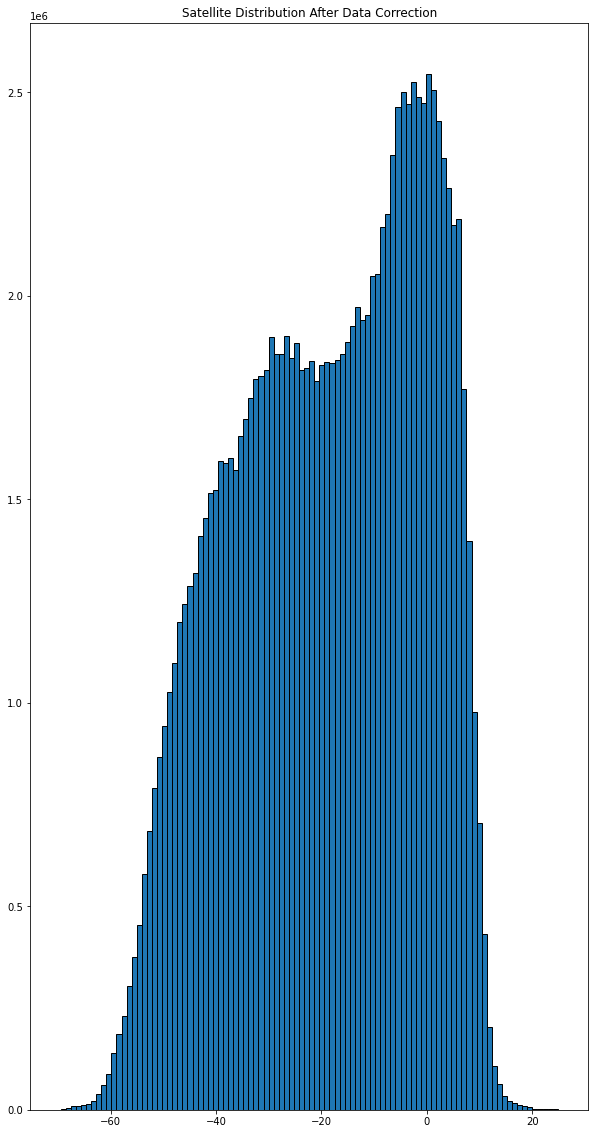

In [ ]:
if not LIMITED_RUN and not without_sat:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,-2:], bins=100)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Satellite Distribution After Data Correction')
    plt.show()

In [ ]:
if not without_sat:
    data_x[..., :,:,:,-2:] = np.clip(data_x[:,:,:,-2:], -69.0, 20.0)

In [ ]:
if not without_sat:
    global_sat_mean = np.mean(data_x[:,:,:,-2:])
    global_sat_std = np.std(data_x[:,:,:,-2:])
    print("global_sat_mean:", global_sat_mean)
    print("global_sat_std:", global_sat_std)
    if not LIMITED_RUN:
        global_sat_max = np.max(data_x[:,:,:,-2:])
        global_sat_min = np.min(data_x[:,:,:,-2:])
        print("global_sat_max:", global_sat_max)
        print("global_sat_min:", global_sat_min)

-18.722265
17.814646
20.0
-69.0


In [ ]:
# Commented
if not without_sat:
    data_x[...,:,:,:,-2:] =  -((data_x[:,:,:,-2:] - global_sat_mean)/global_sat_std)

less than -1.9238253 : 66988
less than -1.6740308 : 504536
less than -1.4242363 : 5041041
less than -1.1744418 : 10386254
less than -0.9246474 : 11554440
less than -0.6748529 : 11370478
less than -0.42505845 : 9791717
less than -0.17526397 : 8925329
less than 0.0745305 : 8508633
less than 0.32432497 : 8447023
less than 0.57411945 : 8623327
less than 0.82391393 : 8402552
less than 1.0737084 : 7603019
less than 1.3235029 : 7086626
less than 1.5732973 : 6099468
less than 1.8230917 : 4653881
less than 2.0728862 : 2749395
less than 2.3226807 : 1025336
less than 2.5724752 : 199212


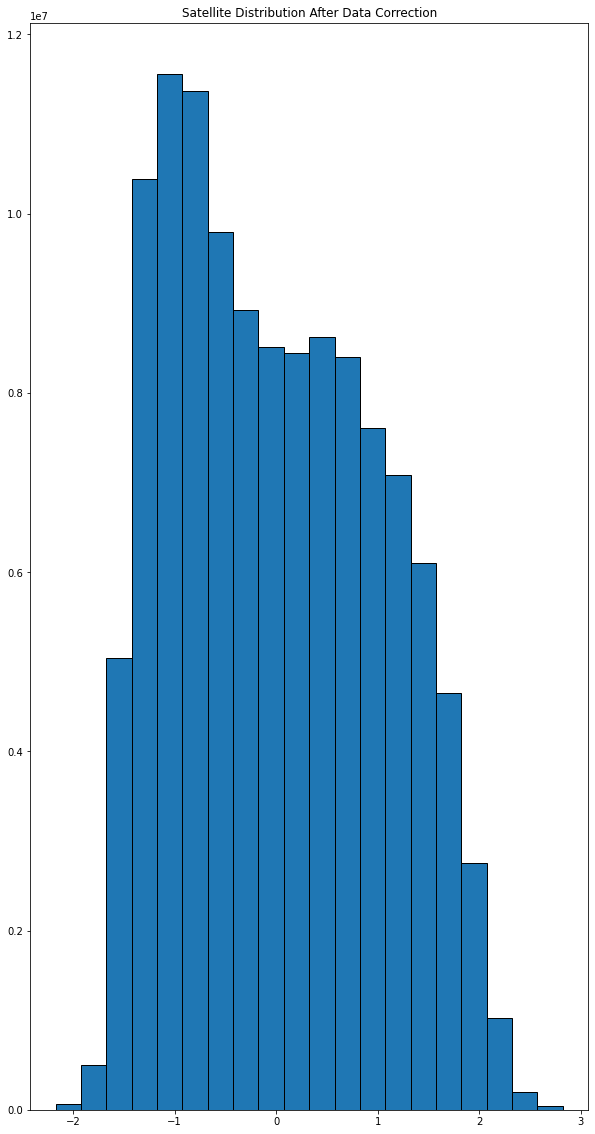

In [ ]:
if not without_sat:
    if not LIMITED_RUN:
        hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,-2:], bins=20)
        for i_ in range(1, len(bin_edges)-1):
            print('less than', bin_edges[i_], ':', hist[i_-1])

        plt.figure(figsize=(10,20))
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
        plt.title('Satellite Distribution After Data Correction')
        plt.show()

In [ ]:
if not without_sat:
    global_sat_mean = np.mean(data_x[:,:,:,-2:])
    global_sat_std = np.std(data_x[:,:,:,-2:])
    print("global_sat_mean:", global_sat_mean)
    print("global_sat_std:", global_sat_std)
    # if not LIMITED_RUN:
    global_sat_max = np.max(data_x[:,:,:,-2:])
    global_sat_min = np.min(data_x[:,:,:,-2:])
    print("global_sat_max:", global_sat_max)
    print("global_sat_min:", global_sat_min)

-2.8888512e-06
0.99999857
2.8222697
-2.1736197


In [ ]:
if not without_sat:
    data_x[...,:,:,:,-2:] =  (data_x[:,:,:,-2:] + abs(global_sat_min))/(abs(global_sat_min) + global_sat_max)

less than 0.05 : 66988
less than 0.1 : 504536
less than 0.15 : 5041041
less than 0.2 : 10386254
less than 0.25 : 11554440
less than 0.3 : 11370478
less than 0.35 : 9791717
less than 0.4 : 8925329
less than 0.45 : 8508633
less than 0.5 : 8447023
less than 0.55 : 8623327
less than 0.6 : 8402552
less than 0.65 : 7603015
less than 0.7 : 7086630
less than 0.75 : 6099468
less than 0.8 : 4653881
less than 0.85 : 2749413
less than 0.9 : 1025318
less than 0.95 : 199212


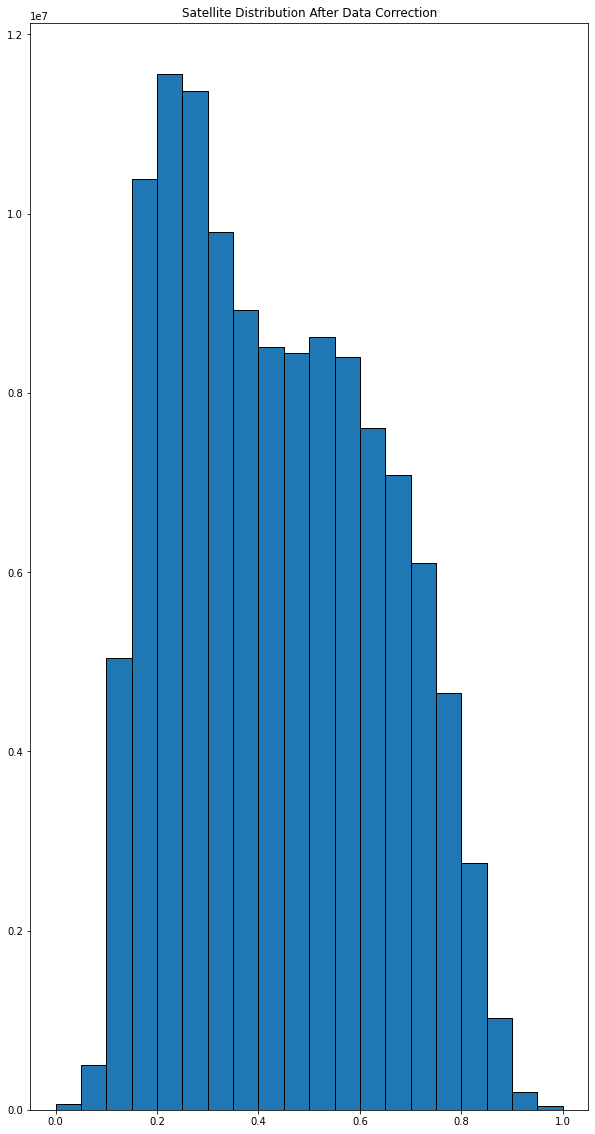

In [ ]:
if not without_sat:
    if not LIMITED_RUN:
        hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,-2:], bins=20)
        for i_ in range(1, len(bin_edges)-1):
            print('less than', bin_edges[i_], ':', hist[i_-1])

        plt.figure(figsize=(10,20))
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
        plt.title('Satellite Distribution After Data Correction')
        plt.show()

In [ ]:
if not without_sat:
    global_sat_mean = np.mean(data_x[:,:,:,-2:])
    global_sat_std = np.std(data_x[:,:,:,-2:])
    print(global_sat_mean)
    print(global_sat_std)
    # if not LIMITED_RUN:
    global_sat_max = np.max(data_x[:,:,:,-2:])
    global_sat_min = np.min(data_x[:,:,:,-2:])
    print(global_sat_max)
    print(global_sat_min)

0.43508062
0.20016453
1.0
0.0


## 3.3 Wind Data Prep

### 3.3.1 U Component

In [ ]:
dataset_dict['X'].shape

(3695, 128, 128, 11)

In [ ]:
dataset_dict['X'][:,:,:,5:7].shape

(3695, 128, 128, 2)

less than -16.292915 : 21419
less than -13.581055 : 335868
less than -10.869193 : 473641
less than -8.157331 : 1321475
less than -5.4454694 : 3758261
less than -2.7336078 : 9708458
less than -0.021745969 : 17337407
less than 2.6901157 : 25129803
less than 5.4019775 : 23644110
less than 8.113839 : 16187224
less than 10.825701 : 10355657
less than 13.537562 : 6703245
less than 16.249424 : 4056245
less than 18.961287 : 1506450
less than 21.673147 : 439538
less than 24.38501 : 85587
less than 27.09687 : 11388
less than 29.808733 : 1642
less than 32.520596 : 234


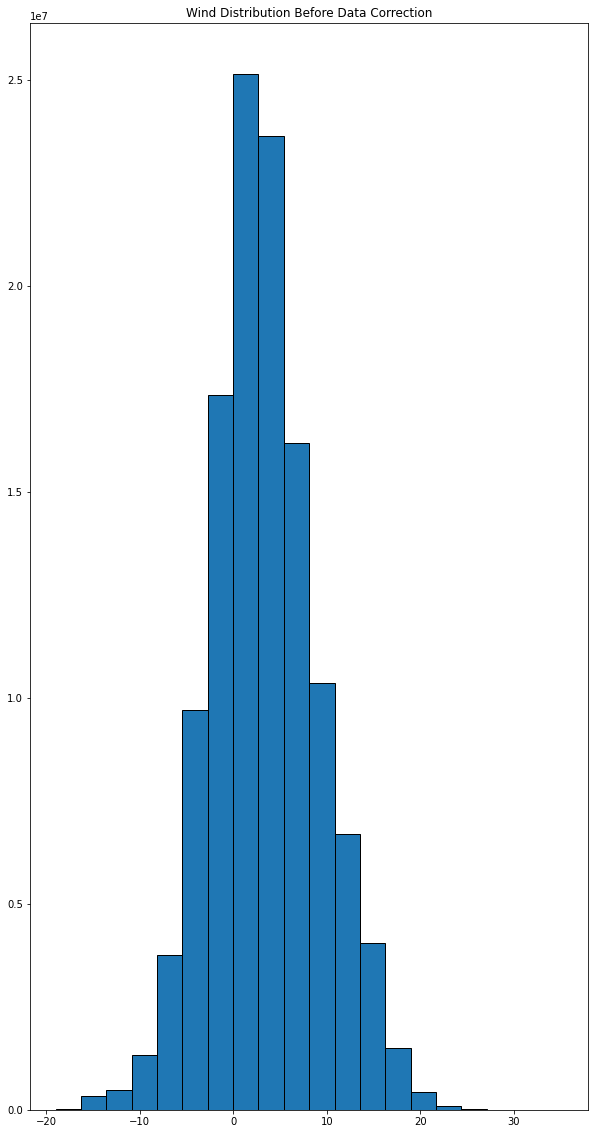

In [ ]:
if not LIMITED_RUN and not without_wind:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,5:7], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Wind Distribution Before Data Correction')
    plt.show()

In [ ]:
if not without_wind:
    data_x[..., :,:,:,5:7] = np.clip(data_x[:,:,:,5:7], -16.0, 32.0)
if not without_wind:
    global_wind_u_mean = np.mean(data_x[:,:,:,5:7])
    global_wind_u_std = np.std(data_x[:,:,:,5:7])
    print(global_wind_u_mean)
    print(global_wind_u_std)
    if not LIMITED_RUN:
        global_wind_u_max = np.max(data_x[:,:,:,5:7])
        global_wind_u_min = np.min(data_x[:,:,:,5:7])
        print(global_wind_u_max)
        print(global_wind_u_min)

3.3327858
5.6883087
32.0
-16.0


In [ ]:
# Commented
if not without_wind:
    data_x[...,:,:,:,5:7] =  (data_x[:,:,:,5:7] - global_wind_u_mean)/global_wind_u_std

less than -2.9767702 : 354490
less than -2.554852 : 397650
less than -2.132934 : 945515
less than -1.7110159 : 2471786
less than -1.289098 : 5784172
less than -0.86717993 : 12196346
less than -0.44526193 : 17630257
less than -0.023343896 : 23327691
less than 0.3985741 : 20032090
less than 0.82049215 : 14221441
less than 1.2424102 : 9612510
less than 1.6643282 : 6444419
less than 2.0862463 : 4374638
less than 2.5081642 : 2236193
less than 2.9300823 : 740181
less than 3.3520002 : 252857
less than 3.7739184 : 45277
less than 4.1958365 : 8403
less than 4.6177545 : 1470


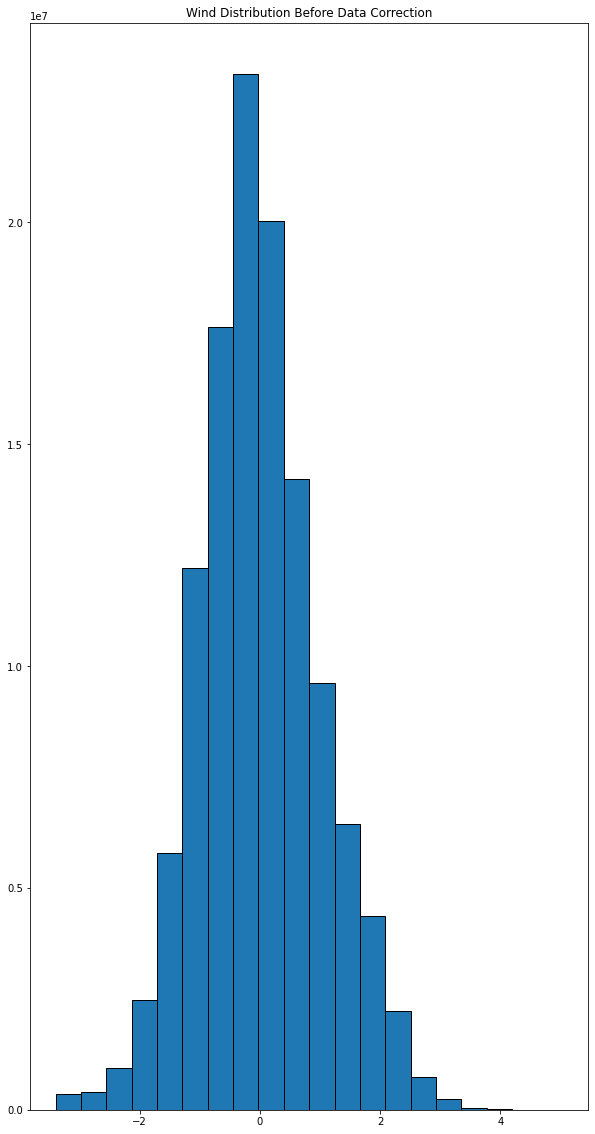

In [ ]:
if not LIMITED_RUN and not without_wind:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,5:7], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Wind Distribution Before Data Correction')
    plt.show()

In [ ]:
if not without_wind:
    global_wind_u_mean = np.mean(data_x[:,:,:,5:7])
    global_wind_u_std = np.std(data_x[:,:,:,5:7])
    print(global_wind_u_mean)
    print(global_wind_u_std)
    # if not LIMITED_RUN:
    global_wind_u_max = np.max(data_x[:,:,:,5:7])
    global_wind_u_min = np.min(data_x[:,:,:,5:7])
    print(global_wind_u_max)
    print(global_wind_u_min)

3.777273e-07
1.0000005
5.0396724
-3.398688


In [ ]:
# Commented
if not without_wind:
    data_x[...,:,:,:,5:7] =  (data_x[:,:,:,5:7] + abs(global_wind_u_min))/(abs(global_wind_u_min) + global_wind_u_max)

less than 0.05 : 354490
less than 0.1 : 397650
less than 0.15 : 945515
less than 0.2 : 2471786
less than 0.25 : 5784168
less than 0.3 : 12196350
less than 0.35 : 17630249
less than 0.4 : 23327687
less than 0.45 : 20032086
less than 0.5 : 14221447
less than 0.55 : 9612505
less than 0.6 : 6444434
less than 0.65 : 4374628
less than 0.7 : 2236203
less than 0.75 : 740181
less than 0.8 : 252855
less than 0.85 : 45279
less than 0.9 : 8403
less than 0.95 : 1470


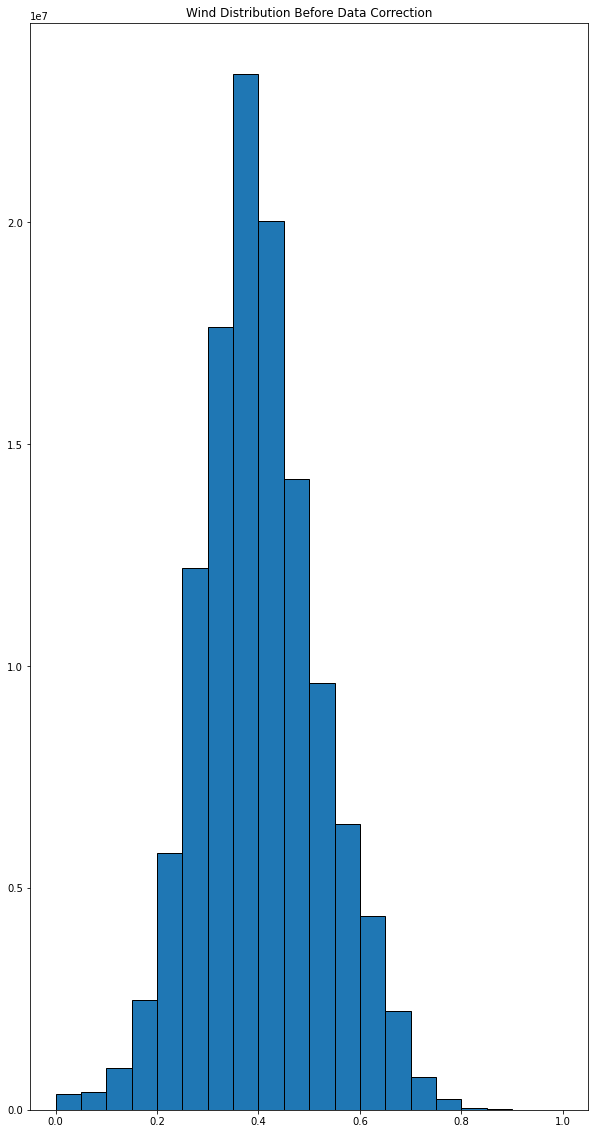

In [ ]:
if not LIMITED_RUN and not without_wind:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,5:7], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Wind Distribution Before Data Correction')
    plt.show()

In [ ]:
if not without_wind:
    global_wind_u_mean = np.mean(data_x[:,:,:,5:7])
    global_wind_u_std = np.std(data_x[:,:,:,5:7])
    print(global_wind_u_mean)
    print(global_wind_u_std)
    # if not LIMITED_RUN:
    global_wind_u_max = np.max(data_x[:,:,:,5:7])
    global_wind_u_min = np.min(data_x[:,:,:,5:7])
    print(global_wind_u_max)
    print(global_wind_u_min)

0.40276662
0.11850648
1.0
0.0


### 3.3.2 V Component

In [ ]:
dataset_dict['X'][:,:,:,7:9].shape

(3695, 128, 128, 2)

less than -22.021297 : 860
less than -19.515156 : 16135
less than -17.009014 : 141145
less than -14.502871 : 311505
less than -11.996728 : 1021849
less than -9.490585 : 2856481
less than -6.9844427 : 4775513
less than -4.4783 : 8682705
less than -1.9721575 : 15340390
less than 0.53398514 : 18881142
less than 3.0401278 : 20816356
less than 5.5462704 : 19101893
less than 8.052413 : 13633000
less than 10.558556 : 8162426
less than 13.064698 : 4421349
less than 15.570841 : 1921557
less than 18.076984 : 665177
less than 20.583126 : 257055
less than 23.089268 : 70580


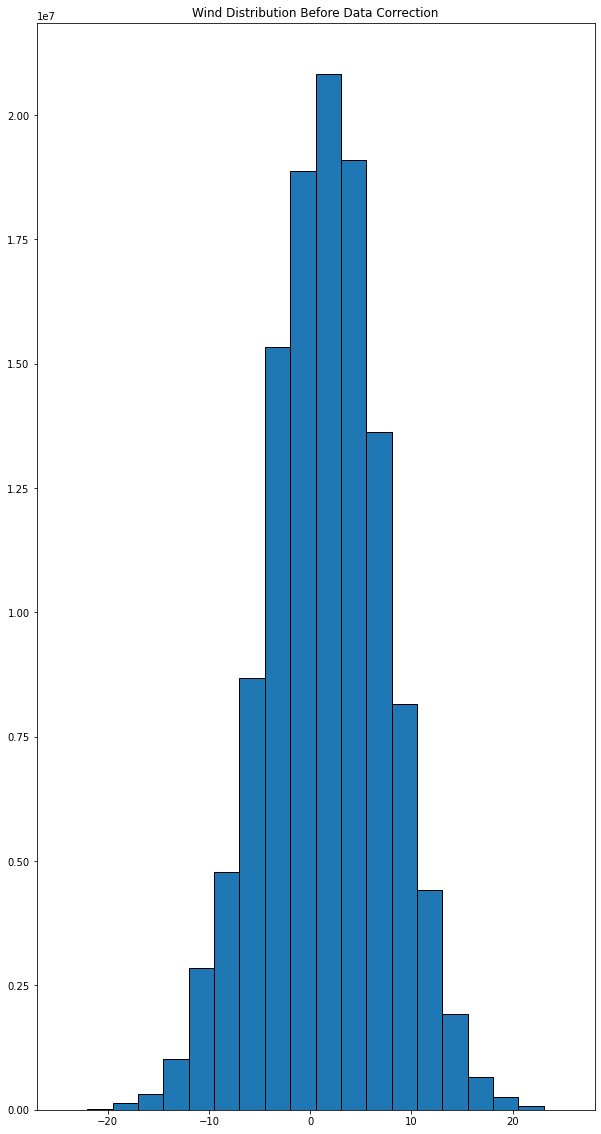

In [ ]:
if not LIMITED_RUN and not without_wind:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,7:9], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Wind Distribution Before Data Correction')
    plt.show()

In [ ]:
if not without_wind:
    data_x[..., :,:,:,7:9] = np.clip(data_x[:,:,:,7:9], -22.0, 23.0)
if not without_wind:
    global_wind_v_mean = np.mean(data_x[:,:,:,7:9])
    global_wind_v_std = np.std(data_x[:,:,:,7:9])
    print(global_wind_v_mean)
    print(global_wind_v_std)
    if not LIMITED_RUN:
        global_wind_v_max = np.max(data_x[:,:,:,7:9])
        global_wind_v_min = np.min(data_x[:,:,:,7:9])
        print(global_wind_v_max)
        print(global_wind_v_min)

1.4959785
5.868878
23.0
-22.0


In [ ]:
# Commented
if not without_wind:
    data_x[...,:,:,:,7:9] =  (data_x[:,:,:,7:9] - global_wind_v_mean)/global_wind_v_std

less than -3.6201093 : 13086
less than -3.236731 : 111081
less than -2.8533528 : 221139
less than -2.4699748 : 605318
less than -2.0865965 : 1627067
less than -1.7032182 : 3500565
less than -1.31984 : 5021686
less than -0.93646175 : 9095114
less than -0.5530835 : 14548983
less than -0.16970527 : 17013179
less than 0.21367297 : 18604424
less than 0.5970512 : 17959780
less than 0.9804294 : 13506468
less than 1.3638077 : 8995563
less than 1.747186 : 5416398
less than 2.1305642 : 2883683
less than 2.5139422 : 1214628
less than 2.8973205 : 469219
less than 3.2806988 : 210212


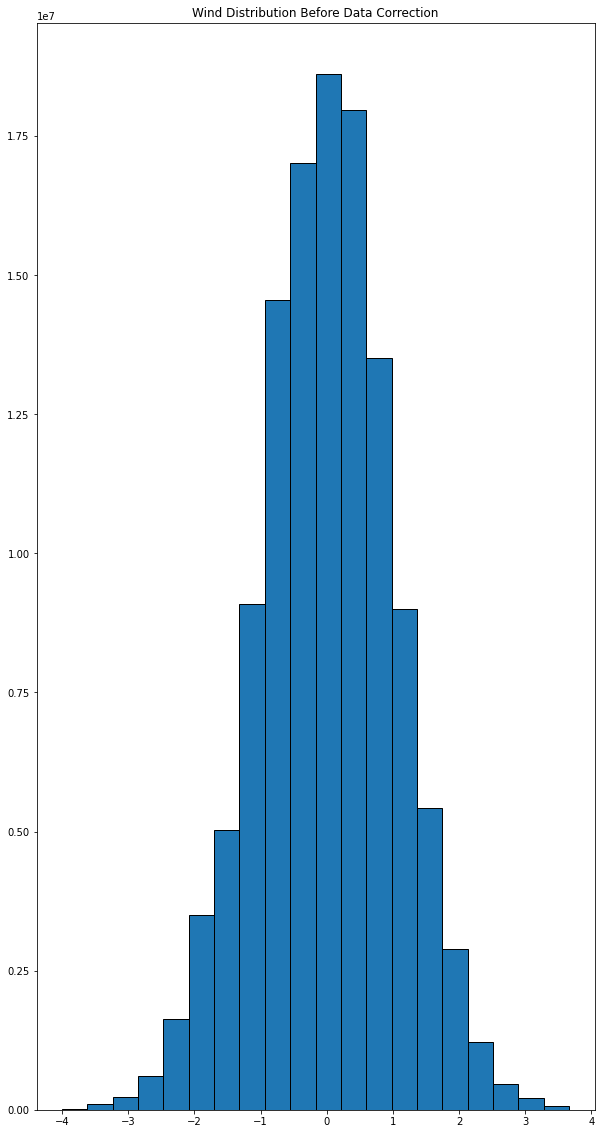

In [ ]:
if not LIMITED_RUN and not without_wind:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,7:9], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Wind Distribution Before Data Correction')
    plt.show()

In [ ]:
if not without_wind:
    global_wind_u_mean = np.mean(data_x[:,:,:,7:9])
    global_wind_u_std = np.std(data_x[:,:,:,7:9])
    print(global_wind_u_mean)
    print(global_wind_u_std)
    # if not LIMITED_RUN:
    global_wind_u_max = np.max(data_x[:,:,:,7:9])
    global_wind_u_min = np.min(data_x[:,:,:,7:9])
    print(global_wind_u_max)
    print(global_wind_u_min)

8.225884e-08
0.99999934
3.664077
-4.0034876


In [ ]:
# Commented
if not without_wind:
    data_x[...,:,:,:,7:9] =  (data_x[:,:,:,7:9] + abs(global_wind_u_min))/(abs(global_wind_u_min) + global_wind_u_max)

less than 0.05 : 13086
less than 0.1 : 111081
less than 0.15 : 221139
less than 0.2 : 605318
less than 0.25 : 1627067
less than 0.3 : 3500565
less than 0.35 : 5021681
less than 0.4 : 9095119
less than 0.45 : 14548978
less than 0.5 : 17013172
less than 0.55 : 18604436
less than 0.6 : 17959769
less than 0.65 : 13506466
less than 0.7 : 8995564
less than 0.75 : 5416405
less than 0.8 : 2883688
less than 0.85 : 1214628
less than 0.9 : 469219
less than 0.95 : 210212


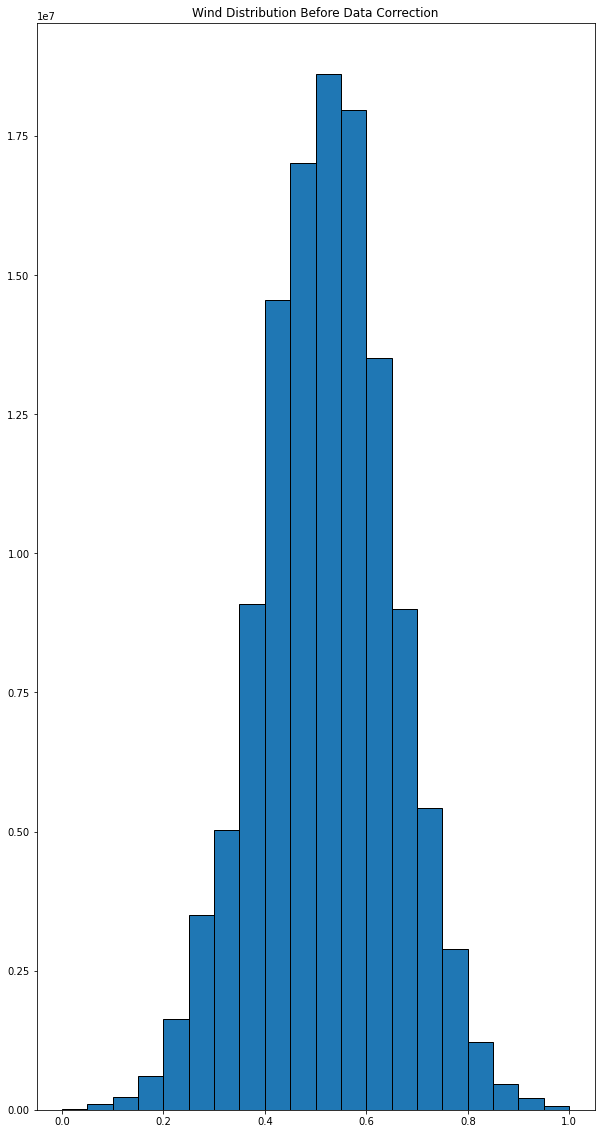

In [ ]:
if not LIMITED_RUN and not without_wind:
    hist, bin_edges = np.histogram(dataset_dict['X'][:,:,:,7:9], bins=20)
    for i_ in range(1, len(bin_edges)-1):
        print('less than', bin_edges[i_], ':', hist[i_-1])

    plt.figure(figsize=(10,20))
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
    plt.title('Wind Distribution Before Data Correction')
    plt.show()

In [ ]:
if not without_wind:
    global_wind_u_mean = np.mean(data_x[:,:,:,7:9])
    global_wind_u_std = np.std(data_x[:,:,:,7:9])
    print(global_wind_u_mean)
    print(global_wind_u_std)
    # if not LIMITED_RUN:
    global_wind_u_max = np.max(data_x[:,:,:,7:9])
    global_wind_u_min = np.min(data_x[:,:,:,7:9])
    print(global_wind_u_max)
    print(global_wind_u_min)

0.5221319
0.13041943
1.0
0.0


# Split Train test valid

In [ ]:
dates_csv.to_csv('dates.csv')

In [ ]:
print(dataset_dict['X'].shape)
print(dataset_dict['Y'].shape)
print(dataset_dict['Index'].shape)

(3695, 128, 128, 11)
(3695, 128, 128)
(3695,)


In [ ]:
dataset_dict_indexes = np.array(dataset_dict['Index']).astype(int)

In [ ]:
import datetime


test_indexes_bool_arr = [date.isocalendar()[1]%2==0 for date in dates_csv[dates_csv['date']>=datetime.datetime(2018,1,1)]['date']]

test_indexes_from_csv = np.array(dates_csv[dates_csv['date']>=datetime.datetime(2018,1,1)]['index'])[test_indexes_bool_arr]
valid_indexes_from_csv = np.array(dates_csv[dates_csv['date']>=datetime.datetime(2018,1,1)]['index'])[np.invert(test_indexes_bool_arr)]

In [ ]:
test_indexes_from_csv

array([  84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,
         95,   96,   97,   98,   99,  100,  101,  102,  103,  104,  105,
        106,  107,  108,  109,  110,  111,  112,  113,  114,  115,  116,
        117,  118,  119,  120,  121,  122,  123,  124,  125,  126,  127,
        128,  129,  130,  131,  132,  133,  134,  135,  136,  137,  138,
        139,  140,  141,  142,  143,  144,  145,  146,  147,  148,  149,
        150,  151,  152,  153,  154,  202,  203,  204,  205,  206,  207,
        208,  209,  210,  211,  212,  213,  214,  215,  216,  217,  218,
        219,  220,  221,  222,  223,  224,  225,  226,  227,  228,  229,
        230,  231,  232,  233,  234,  235,  236,  237,  238,  239,  240,
        241,  304,  305,  306,  307,  308,  309,  310,  311,  312,  313,
        314,  315,  316,  317,  318,  374,  375,  376,  377,  378,  414,
        415,  416,  417,  418,  419,  420,  421,  422,  423,  424,  425,
        426,  427,  453,  454,  462,  463,  464,  4

In [ ]:
valid_indexes_from_csv

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,  155,  156,  157,  158,
        159,  160,  161,  162,  163,  164,  165,  166,  167,  168,  169,
        170,  171,  172,  173,  174,  175,  176,  177,  178,  179,  180,
        181,  182,  183,  184,  185,  186,  187,  188,  189,  190,  191,
        192,  193,  194,  195,  196,  197,  198,  199,  200,  201,  242,
        243,  244,  245,  246,  247,  248,  249,  250,  251,  252,  253,
        254,  255,  256,  257,  258,  259,  260,  2

In [ ]:
test_idx = np.searchsorted(dataset_dict_indexes, list(set(dataset_dict_indexes) & set(test_indexes_from_csv)))
valid_idx = np.searchsorted(dataset_dict_indexes, list(set(dataset_dict_indexes) & set(valid_indexes_from_csv)))

In [ ]:
print('test_idx:',len(test_idx))
print('valid_idx:',len(valid_idx))

test_idx: 417
valid_idx: 665


In [ ]:
dt_length = dataset_dict.get('X').shape[0]

train_val_len = int(dt_length) - len(test_idx) - len(valid_idx)
arr = np.array(range(max(np.concatenate((test_idx,valid_idx))) + 1, dt_length))

In [ ]:
train_idx = np.sort(arr)
print('train:valid:test = ', len(train_idx), len(valid_idx), len(test_idx))

train:valid:test =  2613 665 417


In [ ]:
dates_csv[dates_csv['index'].isin(train_idx)]

,file,date,index
1082,data_m2016_1_0,2016-01-01 04:00:00,1082
1083,data_m2016_1_1,2016-01-01 05:00:00,1083
1084,data_m2016_1_2,2016-01-01 06:00:00,1084
1085,data_m2016_1_3,2016-01-01 07:00:00,1085
1086,data_m2016_1_4,2016-01-01 08:00:00,1086
...,...,...,...
3690,data_m2017_12_46,2017-12-31 12:00:00,3690
3691,data_m2017_12_47,2017-12-31 16:00:00,3691
3692,data_m2017_12_48,2017-12-31 17:00:00,3692
3693,data_m2017_12_49,2017-12-31 18:00:00,3693


In [ ]:
dates_csv[dates_csv['index'].isin(valid_idx)]

,file,date,index
0,data_m2018_1_0,2018-01-01 00:00:00,0
1,data_m2018_1_1,2018-01-01 01:00:00,1
2,data_m2018_1_2,2018-01-01 02:00:00,2
3,data_m2018_1_3,2018-01-01 03:00:00,3
4,data_m2018_1_4,2018-01-01 04:00:00,4
...,...,...,...
1077,data_m2018_12_5,2018-12-23 01:00:00,1077
1078,data_m2018_12_6,2018-12-23 02:00:00,1078
1079,data_m2018_12_7,2018-12-23 03:00:00,1079
1080,data_m2018_12_8,2018-12-23 04:00:00,1080


In [ ]:
dates_csv[dates_csv['index'].isin(test_idx)]

,file,date,index
84,data_m2018_1_84,2018-01-09 13:00:00,84
85,data_m2018_1_85,2018-01-09 14:00:00,85
86,data_m2018_1_86,2018-01-09 15:00:00,86
87,data_m2018_1_87,2018-01-09 16:00:00,87
88,data_m2018_1_88,2018-01-09 21:00:00,88
...,...,...,...
1026,data_m2018_12_45,2018-12-16 14:00:00,1026
1027,data_m2018_12_46,2018-12-16 18:00:00,1027
1028,data_m2018_12_47,2018-12-16 19:00:00,1028
1029,data_m2018_12_48,2018-12-16 20:00:00,1029


In [ ]:
dataset_dict.create_dataset('Y_test', (0,128,128), maxshape=(None,128,128))
dataset_dict.create_dataset('Y_valid', (0,128,128), maxshape=(None,128,128))
dataset_dict.create_dataset('X_test', (0,11,128,128),  maxshape=(None,11,128,128))
dataset_dict.create_dataset('X_valid', (0,11,128,128),  maxshape=(None,11,128,128))
dataset_dict.create_dataset('Train_index', (0,), maxshape=(None,),chunks=True)
dataset_dict.create_dataset('Valid_index', (0,), maxshape=(None,),chunks=True)
dataset_dict.create_dataset('Test_index', (0,), maxshape=(None,),chunks=True)

<HDF5 dataset "Test_index": shape (0,), type "<f4">

In [ ]:
data_x_train = dataset_dict['X'][train_idx,:,:,:]
data_x_test = dataset_dict['X'][test_idx,:,:,:]
data_x_valid = dataset_dict['X'][valid_idx,:,:,:]

In [ ]:
data_x_train = np.swapaxes(np.swapaxes(data_x_train, 1, 3), 2, 3)
data_x_test = np.swapaxes(np.swapaxes(data_x_test, 1, 3), 2, 3)
data_x_valid = np.swapaxes(np.swapaxes(data_x_valid, 1, 3), 2, 3)

In [ ]:
dataset_dict_train_idx = dataset_dict['Index'][train_idx]
dataset_dict_valid_idx = dataset_dict['Index'][valid_idx]
dataset_dict_test_idx = dataset_dict['Index'][test_idx]

In [ ]:
dataset_dict['X_valid'].resize((data_x_valid.shape[0]+dataset_dict['X_valid'].shape[0]), axis=0)
dataset_dict['X_valid'][-data_x_valid.shape[0]:] = data_x_valid

dataset_dict['Valid_index'].resize((dataset_dict['X_valid'].shape[0]), axis=0)
dataset_dict['Valid_index'][-data_x_valid.shape[0]:] = dataset_dict_valid_idx

In [ ]:
dataset_dict['X_test'].resize((data_x_test.shape[0]+dataset_dict['X_test'].shape[0]), axis=0)
dataset_dict['X_test'][-data_x_test.shape[0]:] = data_x_test

dataset_dict['Test_index'].resize((dataset_dict['X_test'].shape[0]), axis=0)
dataset_dict['Test_index'][-data_x_test.shape[0]:] = dataset_dict_test_idx

In [ ]:
del dataset_dict['X']
dataset_dict.create_dataset('X', (0,11,128,128),  maxshape=(None,11,128,128))
dataset_dict['X'].resize((data_x_train.shape[0]), axis=0)
dataset_dict['X'][-data_x_train.shape[0]:] = data_x_train

dataset_dict['Train_index'].resize((dataset_dict['X'].shape[0]), axis=0)
dataset_dict['Train_index'][-data_x_train.shape[0]:] = dataset_dict_train_idx
del dataset_dict['Index']

In [ ]:
del data_x_valid
del data_x_test
del data_x_train

In [ ]:
print(dataset_dict['X'].shape)
print(dataset_dict['X_test'].shape)
print(dataset_dict['X_valid'].shape)

(2613, 11, 128, 128)
(417, 11, 128, 128)
(665, 11, 128, 128)


In [ ]:
data_y_train = dataset_dict['Y'][train_idx,:,:]
data_y_test = dataset_dict['Y'][test_idx,:,:]
data_y_valid = dataset_dict['Y'][valid_idx,:,:]

In [ ]:
dataset_dict['Y_valid'].resize((data_y_valid.shape[0]+dataset_dict['Y_valid'].shape[0]), axis=0)
dataset_dict['Y_valid'][-data_y_valid.shape[0]:] = data_y_valid

In [ ]:
dataset_dict['Y_test'].resize((data_y_test.shape[0]+dataset_dict['Y_test'].shape[0]), axis=0)
dataset_dict['Y_test'][-data_y_test.shape[0]:] = data_y_test

In [ ]:
dataset_dict['Y'].resize((data_y_train.shape[0]), axis=0)
dataset_dict['Y'][-data_y_train.shape[0]:] = data_y_train

In [ ]:
del data_y_valid
del data_y_test
del data_y_train

In [ ]:
print(dataset_dict['X'].shape)
print(dataset_dict['X_valid'].shape)
print(dataset_dict['X_test'].shape)

print(dataset_dict['Y'].shape)
print(dataset_dict['Y_valid'].shape)
print(dataset_dict['Y_test'].shape)

print(dataset_dict['Train_index'].shape)
print(dataset_dict['Valid_index'].shape)
print(dataset_dict['Test_index'].shape)

(2613, 11, 128, 128)
(665, 11, 128, 128)
(417, 11, 128, 128)
(2613, 128, 128)
(665, 128, 128)
(417, 128, 128)
(2613,)
(665,)
(417,)


In [ ]:
dates_csv[dates_csv['index'].isin(dataset_dict['Train_index'])]

,file,date,index
1082,data_m2016_1_0,2016-01-01 04:00:00,1082
1083,data_m2016_1_1,2016-01-01 05:00:00,1083
1084,data_m2016_1_2,2016-01-01 06:00:00,1084
1085,data_m2016_1_3,2016-01-01 07:00:00,1085
1086,data_m2016_1_4,2016-01-01 08:00:00,1086
...,...,...,...
3692,data_m2017_12_48,2017-12-31 17:00:00,3692
3693,data_m2017_12_49,2017-12-31 18:00:00,3693
3694,data_m2017_12_50,2017-12-31 19:00:00,3694
3695,data_m2017_12_51,2017-12-31 20:00:00,3695


In [ ]:
dates_csv[dates_csv['index'].isin(dataset_dict['Test_index'])]

,file,date,index
84,data_m2018_1_84,2018-01-09 13:00:00,84
85,data_m2018_1_85,2018-01-09 14:00:00,85
86,data_m2018_1_86,2018-01-09 15:00:00,86
87,data_m2018_1_87,2018-01-09 16:00:00,87
88,data_m2018_1_88,2018-01-09 21:00:00,88
...,...,...,...
1026,data_m2018_12_45,2018-12-16 14:00:00,1026
1027,data_m2018_12_46,2018-12-16 18:00:00,1027
1028,data_m2018_12_47,2018-12-16 19:00:00,1028
1029,data_m2018_12_48,2018-12-16 20:00:00,1029


In [ ]:
dates_csv[dates_csv['index'].isin(dataset_dict['Valid_index'])]

,file,date,index
0,data_m2018_1_0,2018-01-01 00:00:00,0
1,data_m2018_1_1,2018-01-01 01:00:00,1
2,data_m2018_1_2,2018-01-01 02:00:00,2
3,data_m2018_1_3,2018-01-01 03:00:00,3
4,data_m2018_1_4,2018-01-01 04:00:00,4
...,...,...,...
1077,data_m2018_12_5,2018-12-23 01:00:00,1077
1078,data_m2018_12_6,2018-12-23 02:00:00,1078
1079,data_m2018_12_7,2018-12-23 03:00:00,1079
1080,data_m2018_12_8,2018-12-23 04:00:00,1080


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_seq(seq, target=None, pred=None, train_type=3):
    if train_type==0:
        ids=[0,1,2,3,4]
        nrows = 4
        ncols = 4
    elif train_type==1:
        ids=[0,1,2,3,4,9,10]
        nrows = 4
        ncols = 4
    elif train_type==2:
        ids=[0,1,2,3,4,5,6,7,8]
        nrows = 5
        ncols = 4
    elif train_type==3:
        ids=[0,1,2,3,4,5,6,7,8,9,10]
        nrows = 5
        ncols = 4
    fig = plt.figure(figsize=(17*1.56, 17))
    gs = gridspec.GridSpec(nrows=4, ncols=4)
    for i in range(len(ids)):
        fig.add_subplot(gs[i//4, i%4]).pcolormesh(seq[ids[i],:,:])
    if target is not None:
        fig.add_subplot(gs[3:5, 1]).pcolormesh(target)
    if pred is not None:
        fig.add_subplot(gs[3:5, 2]).pcolormesh(pred)
    fig.tight_layout()
    plt.show()

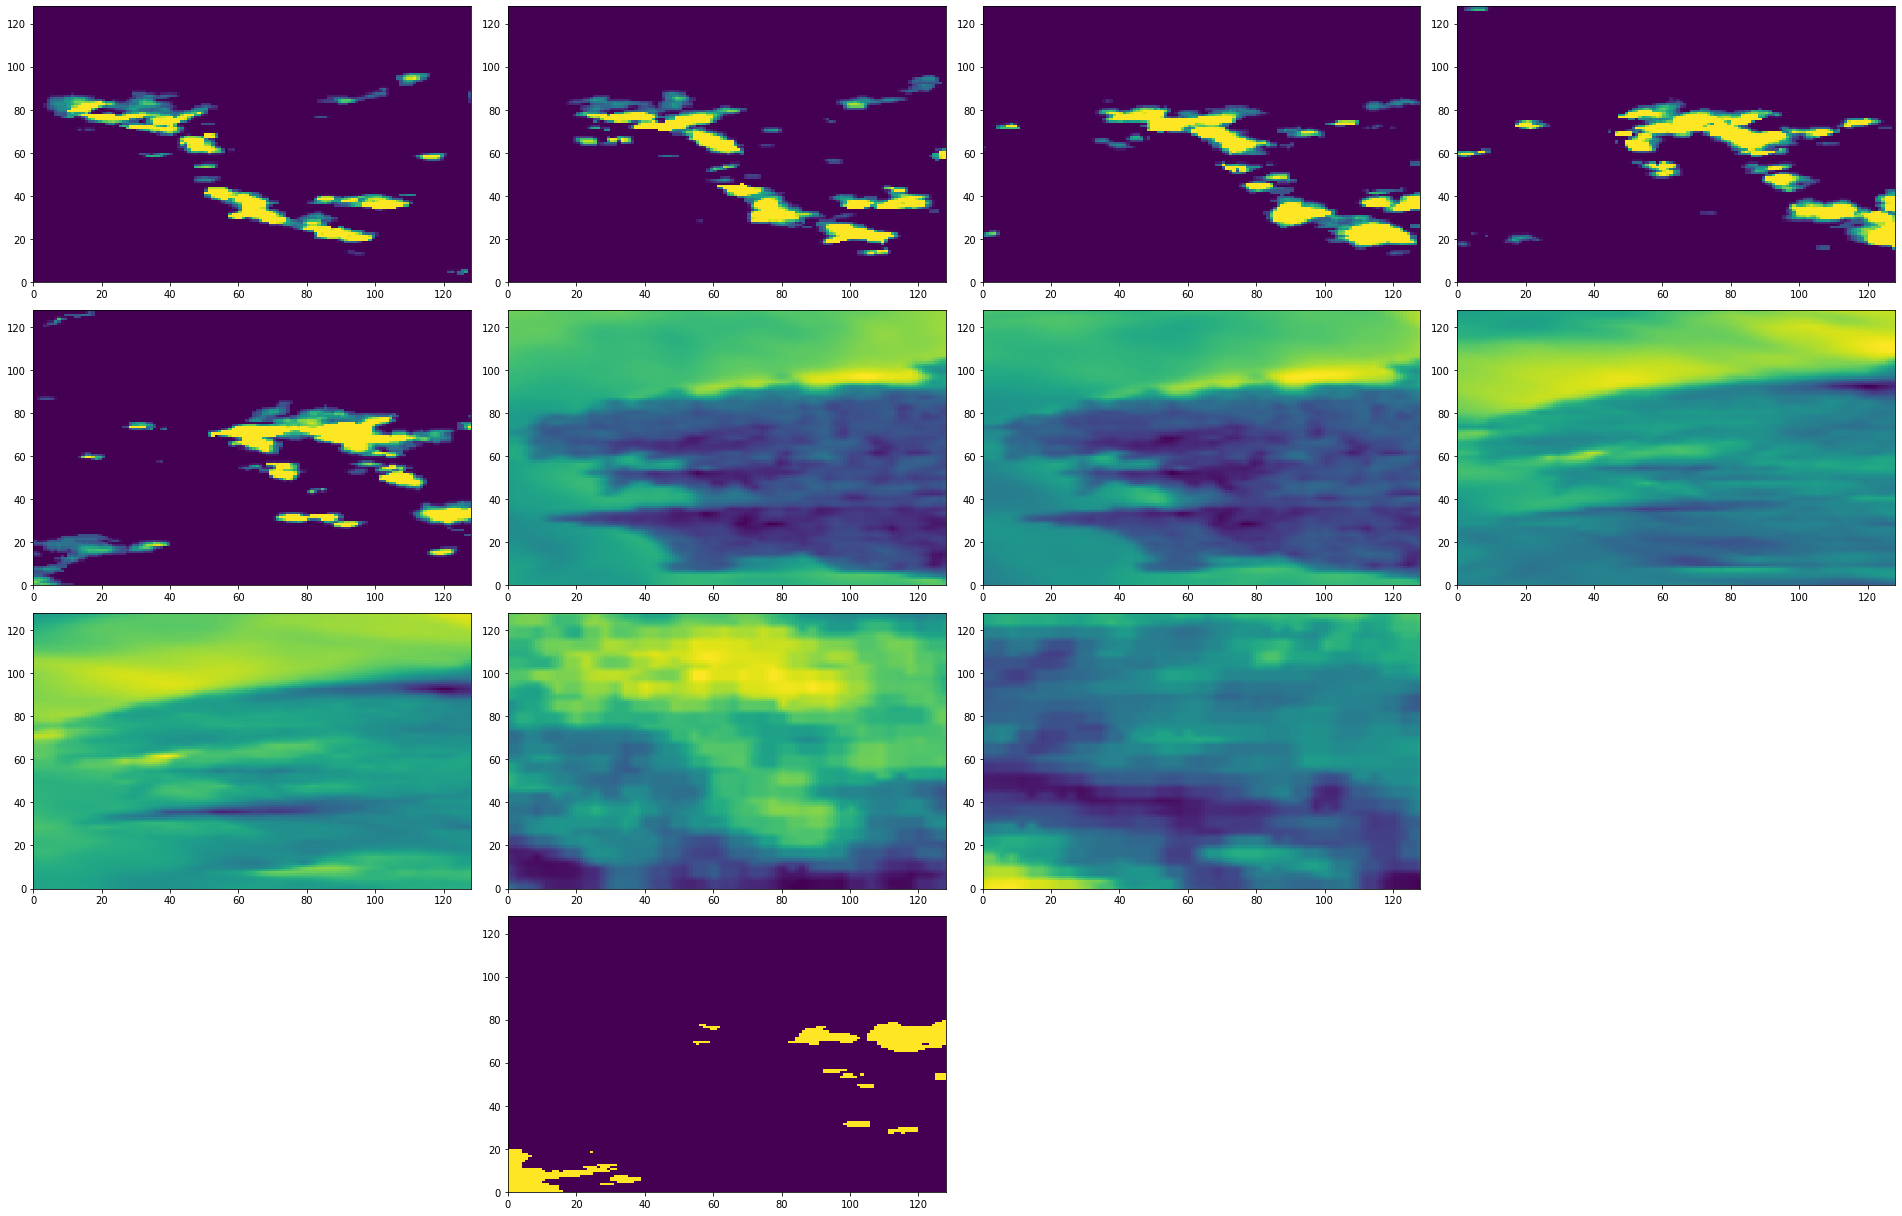

In [ ]:
plot_seq(dataset_dict['X'][1000],dataset_dict['Y'][1000],train_type=3)

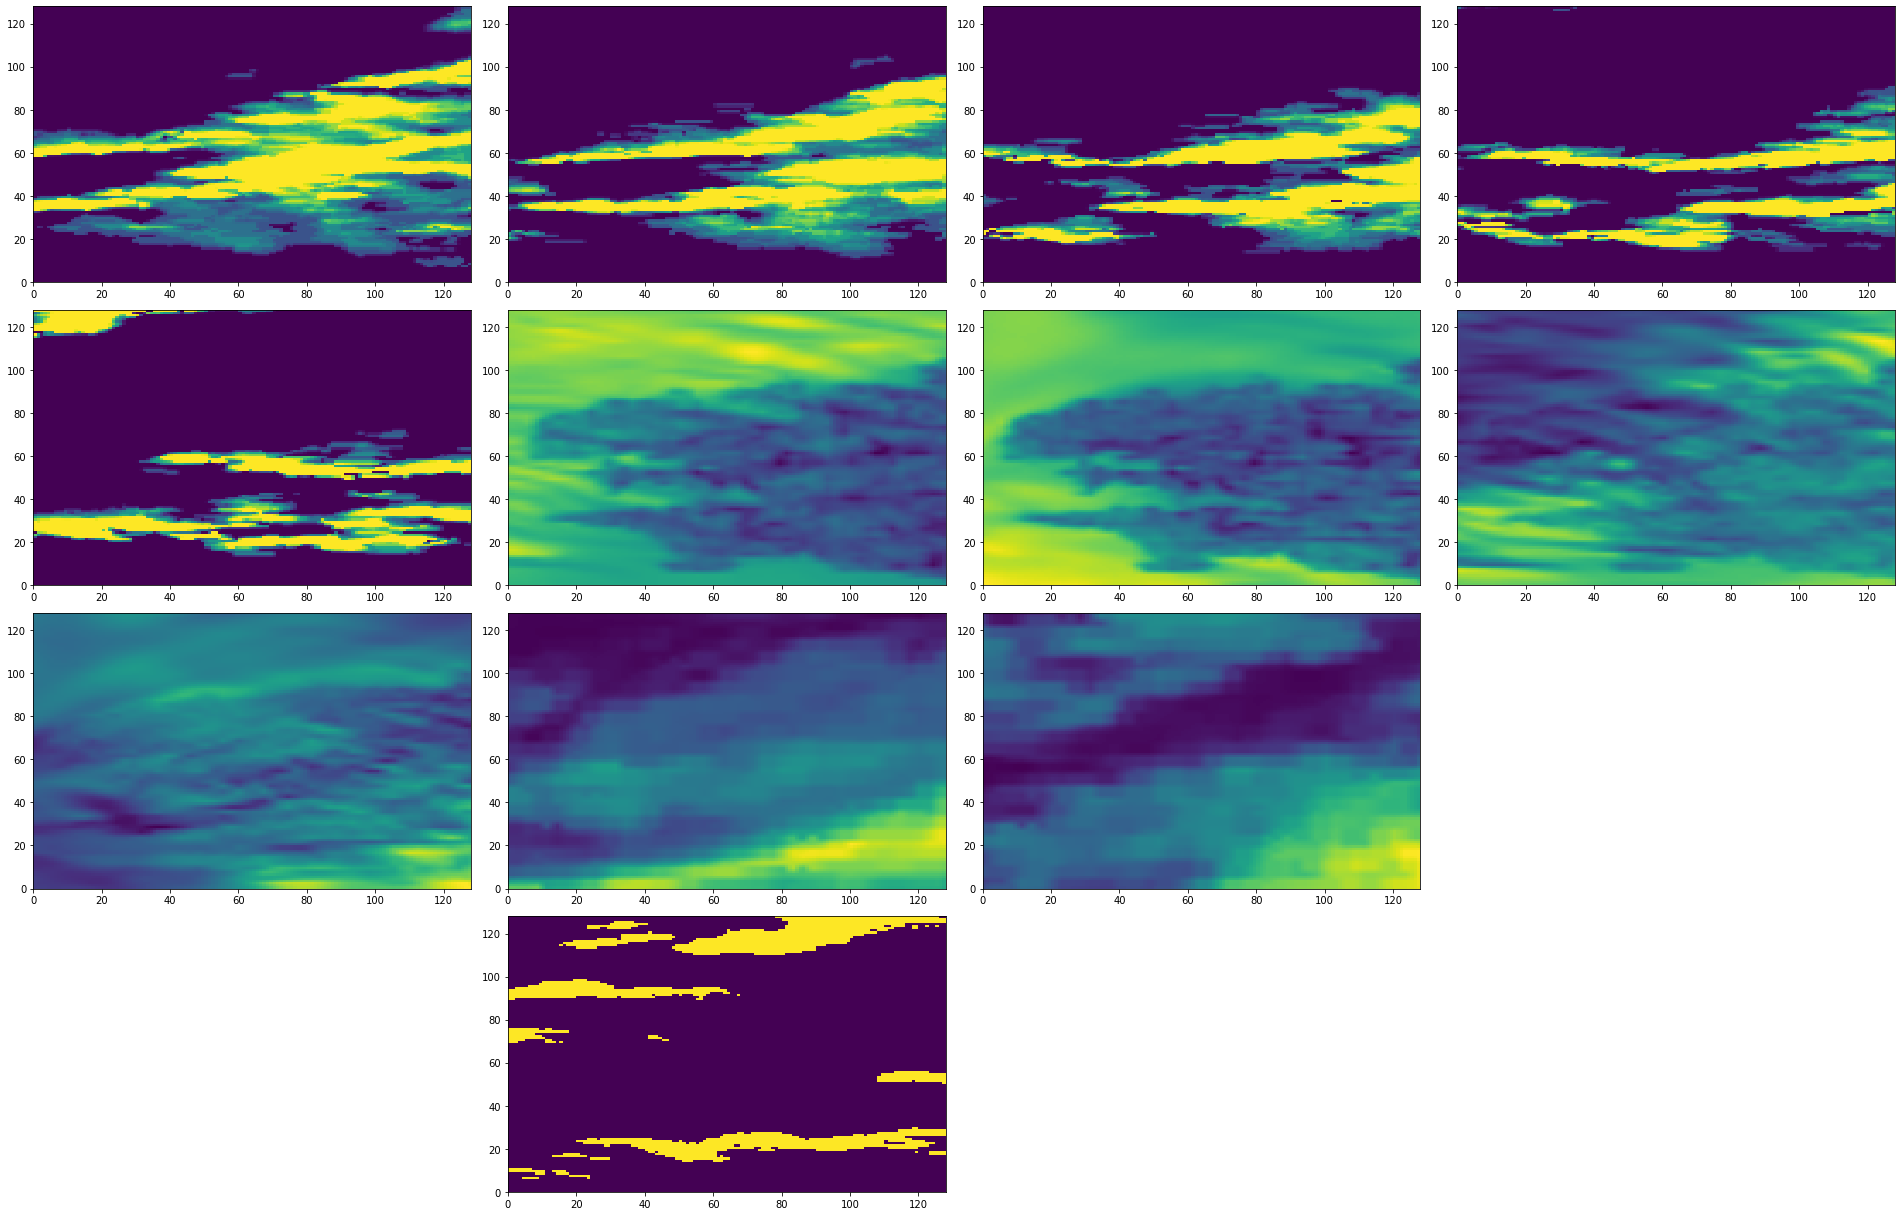

In [ ]:
plot_seq(dataset_dict['X_valid'][12],dataset_dict['Y_valid'][12],train_type=3)

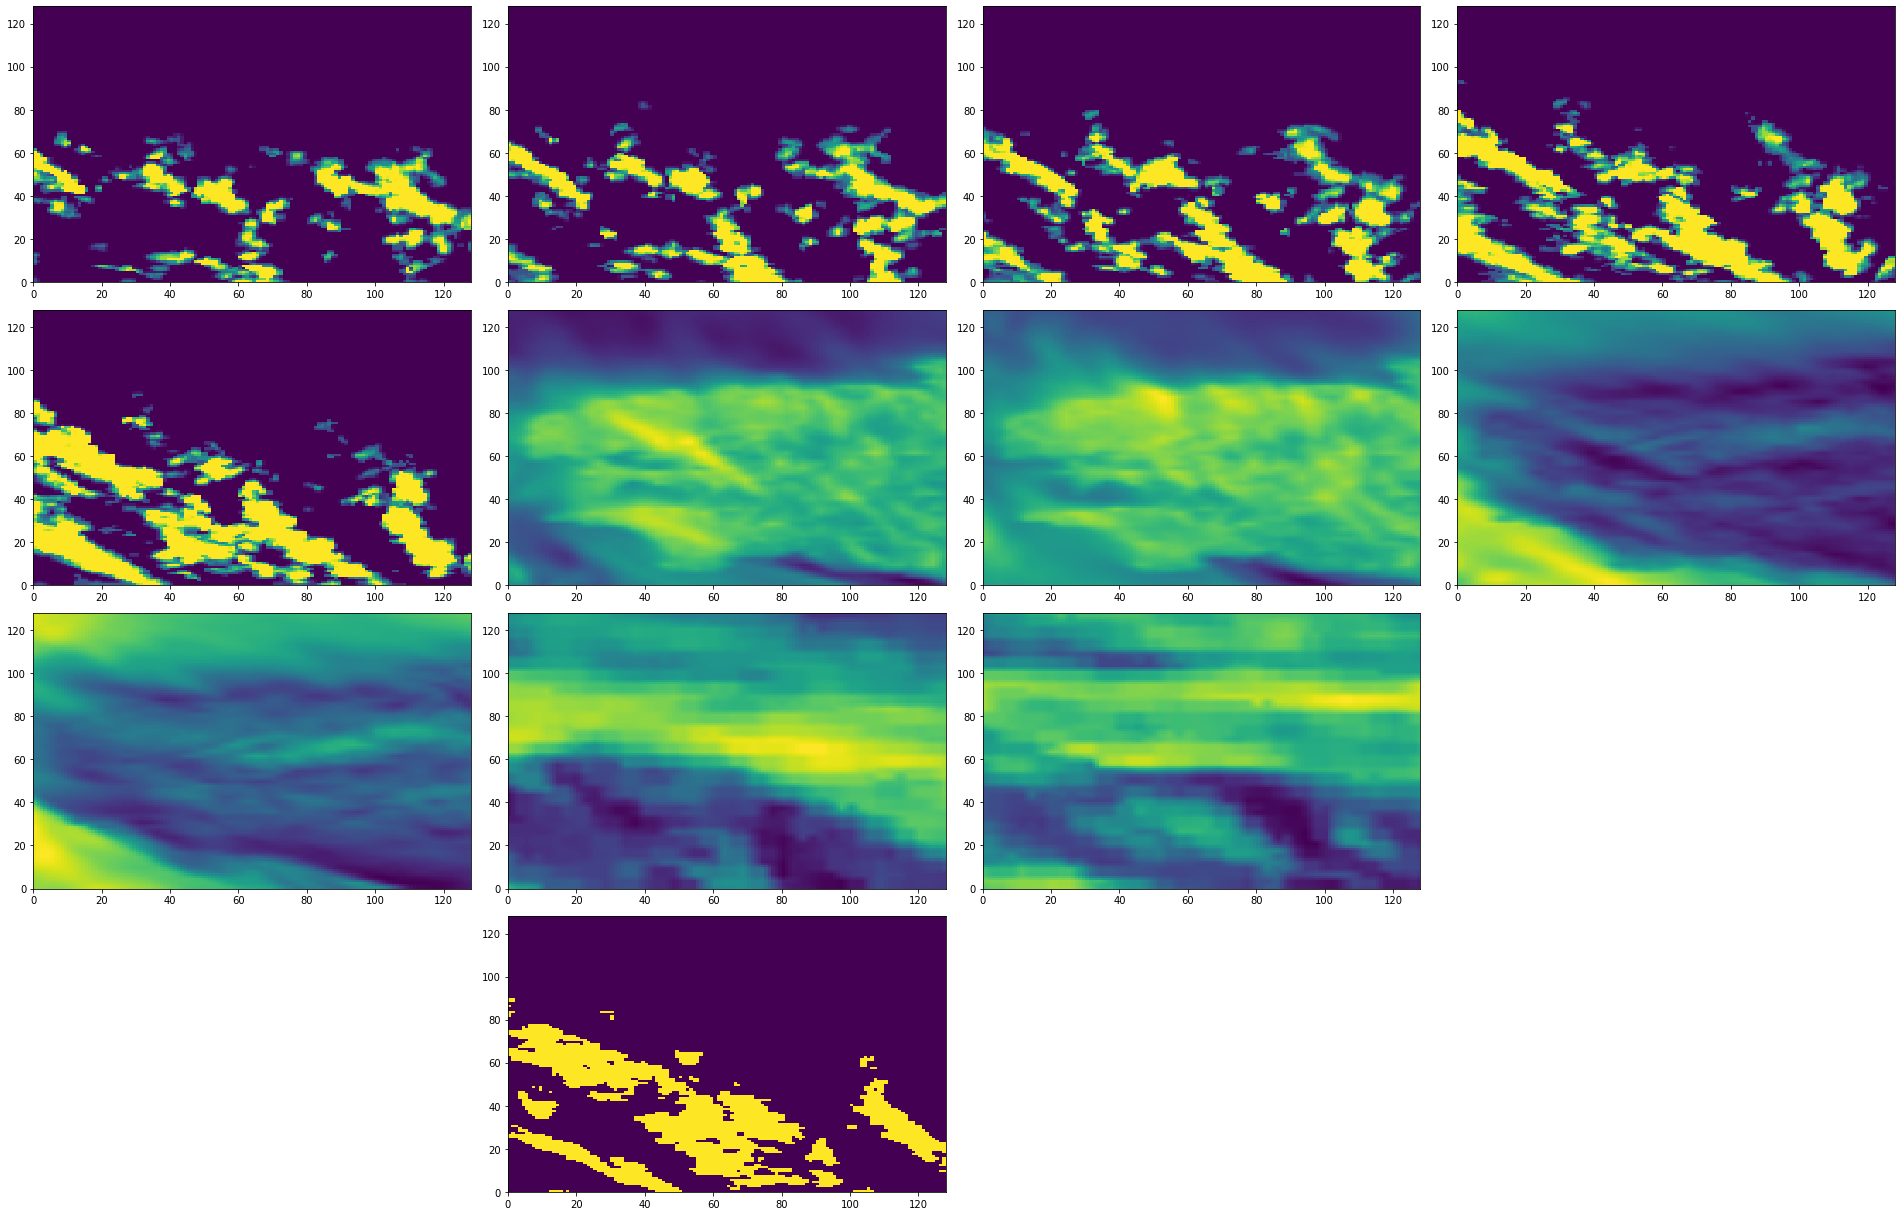

In [ ]:
plot_seq(dataset_dict['X_test'][12],dataset_dict['Y_test'][12],train_type=3)